## Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## Load Dataset from Drive

In [ ]:
import pandas as pd

# Load a sample file
sample_path = '/content/drive/MyDrive/trashnet_enhanced/data/train-00000-of-00100.parquet'
df = pd.read_parquet(sample_path)

# Show the shape and head
print("Shape of the dataset:", df.shape)
df.head()


Shape of the dataset: (199, 2)


,image,label
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0


## Sanity Check and Display Sample Images

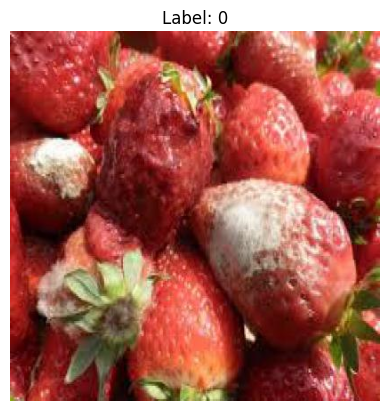

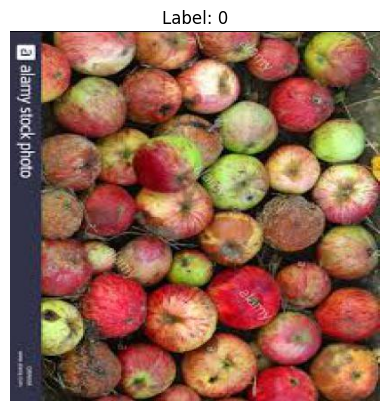

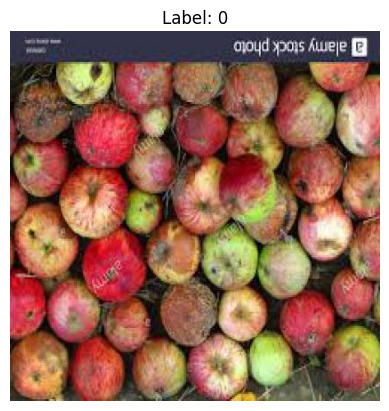

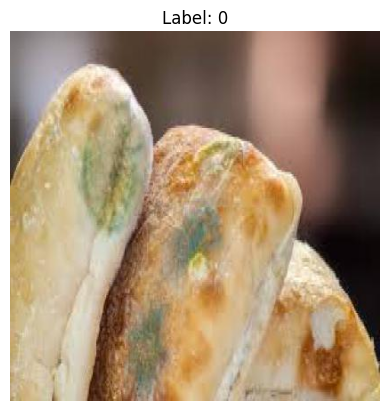

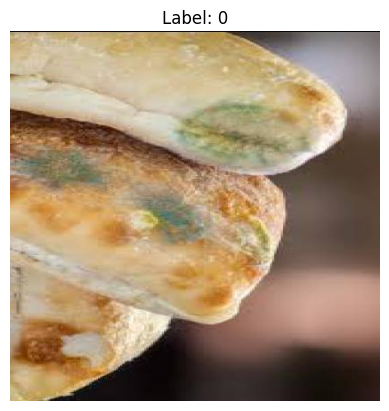

In [ ]:
from PIL import Image
import io
import matplotlib.pyplot as plt

# Display 5 sample images
for i in range(5):
    img_bytes = df.iloc[i]['image']['bytes']
    label = df.iloc[i]['label']

    image = Image.open(io.BytesIO(img_bytes))

    plt.figure()
    plt.imshow(image)
    plt.title(f"Label: {label}")
    plt.axis("off")
    plt.show()


## Combining the Dataset

In [ ]:
import os

# Define the dataset directory
base_path = '/content/drive/MyDrive/trashnet_enhanced/data'

# List all Parquet files in the directory
parquet_files = [os.path.join(base_path, f) for f in os.listdir(base_path) if f.endswith('.parquet')]

# Load and concatenate all DataFrames
all_dfs = [pd.read_parquet(f) for f in parquet_files]
full_df = pd.concat(all_dfs, ignore_index=True)

# Show shape and head
print("Total samples:", full_df.shape)
full_df.head()

Total samples: (19892, 2)


,image,label
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,4
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,4
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,4
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,4
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,4


## Resize, Convert, and Clean Image Data

In [ ]:
from PIL import Image, UnidentifiedImageError
from tqdm import tqdm

# Set fixed size
TARGET_SIZE = (224, 224)

# Create new lists to store cleaned data
clean_images = []
clean_labels = []

# Loop through each row and clean
for i in tqdm(range(len(full_df))):
    try:
        # Read image bytes
        img_bytes = full_df.iloc[i]['image']['bytes']

        # Convert to PIL image
        img = Image.open(io.BytesIO(img_bytes)).convert("RGB")
        img = img.resize(TARGET_SIZE)

        clean_images.append(img)
        clean_labels.append(full_df.iloc[i]['label'])

    except (UnidentifiedImageError, KeyError, TypeError) as e:

        continue

# Create cleaned DataFrame (optional)
clean_df = pd.DataFrame({'image': clean_images, 'label': clean_labels})

print("Cleaned dataset shape:", clean_df.shape)


100%|██████████| 19892/19892 [08:18<00:00, 39.94it/s] 


Cleaned dataset shape: (19892, 2)


## Import Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image


## Define PyTorch Dataset Class

In [ ]:
class TrashNetDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image = self.df.loc[idx, 'image']
        label = self.df.loc[idx, 'label']

        if self.transform:
            image = self.transform(image)

        return image, label


## Apply Data Augmentation and Transforms

In [ ]:
# Augmented training transform
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Simpler transform for val/test
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])


## Split Data into Train, Validation, and Test Sets

In [ ]:
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(clean_df, test_size=0.3, stratify=clean_df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.33, stratify=temp_df['label'], random_state=42)

train_dataset = TrashNetDataset(train_df, transform=train_transform)
val_dataset = TrashNetDataset(val_df, transform=val_test_transform)
test_dataset = TrashNetDataset(test_df, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)


## Define CNN Model

In [ ]:
from torchvision.models import resnet50

class ResNet50WithDropout(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.base = models.resnet50(pretrained=True)
        self.base.fc = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(self.base.fc.in_features, num_classes)
        )

    def forward(self, x):
        return self.base(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = clean_df['label'].nunique()
model = ResNet50WithDropout(num_classes).to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 48.9MB/s]


## Define Training and Validation Function (with Early Stopping & Scheduler)

In [ ]:
def train_model(model, train_loader, val_loader, num_epochs=30, lr=0.001, patience=5):
    import torch
    import torch.nn as nn
    import torch.optim as optim

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    history = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": []
    }

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Early stopping setup
    best_val_acc = 0
    trigger_times = 0

    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = correct / total
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_loss /= val_total
        val_acc = val_correct / val_total
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] - "
              f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f} - "
              f"Val Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")

        scheduler.step()

        # Early stopping logic
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            trigger_times = 0
        else:
            trigger_times += 1
            print(f"Early stopping trigger count: {trigger_times}/{patience}")

            if trigger_times >= patience:
                print("Early stopping activated.")
                break

    return model, history




## Plot Training vs Validation Loss & Accuracy

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label='Train Loss')
    plt.plot(epochs, history["val_loss"], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train vs Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_acc"], label='Train Acc')
    plt.plot(epochs, history["val_acc"], label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Train vs Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


## Train the Model and Track History

Epoch [1/30] - Train Loss: 1.1666 | Acc: 0.5875 - Val Loss: 0.9097 | Acc: 0.6801
Epoch [2/30] - Train Loss: 0.8811 | Acc: 0.6946 - Val Loss: 0.8519 | Acc: 0.7039
Epoch [3/30] - Train Loss: 0.7624 | Acc: 0.7366 - Val Loss: 0.7837 | Acc: 0.7399
Epoch [4/30] - Train Loss: 0.7120 | Acc: 0.7481 - Val Loss: 0.8204 | Acc: 0.7224
Early stopping trigger count: 1/5
Epoch [5/30] - Train Loss: 0.6711 | Acc: 0.7680 - Val Loss: 0.5848 | Acc: 0.8032
Epoch [6/30] - Train Loss: 0.5292 | Acc: 0.8169 - Val Loss: 0.4260 | Acc: 0.8539
Epoch [7/30] - Train Loss: 0.4833 | Acc: 0.8332 - Val Loss: 0.4729 | Acc: 0.8457
Early stopping trigger count: 1/5
Epoch [8/30] - Train Loss: 0.4595 | Acc: 0.8381 - Val Loss: 0.4997 | Acc: 0.8382
Early stopping trigger count: 2/5
Epoch [9/30] - Train Loss: 0.4343 | Acc: 0.8480 - Val Loss: 0.3810 | Acc: 0.8677
Epoch [10/30] - Train Loss: 0.4335 | Acc: 0.8508 - Val Loss: 0.4294 | Acc: 0.8617
Early stopping trigger count: 1/5
Epoch [11/30] - Train Loss: 0.3388 | Acc: 0.8854 - Va

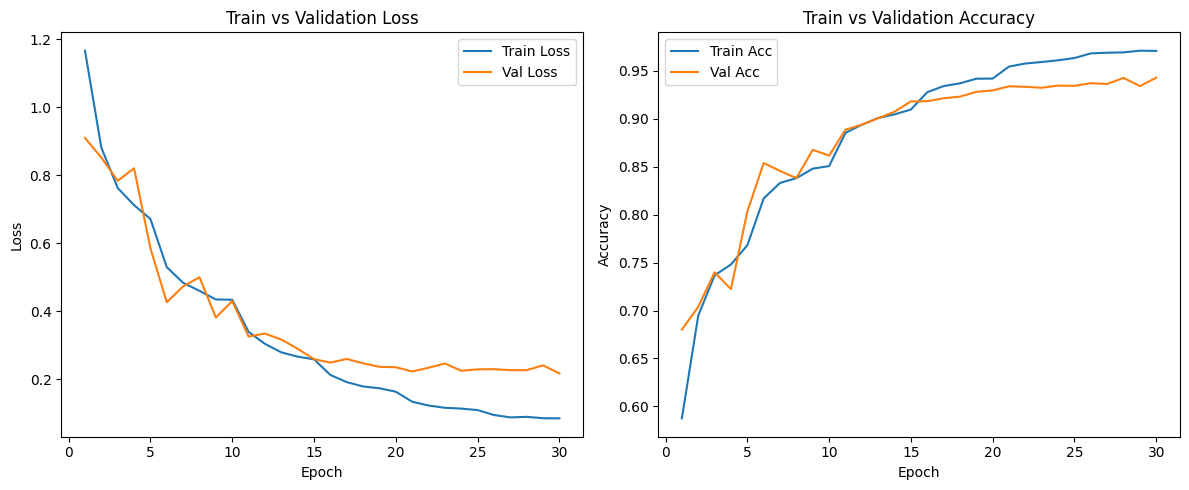

In [ ]:
model, history = train_model(model, train_loader, val_loader, num_epochs=30, lr=0.001, patience=5)
plot_training_history(history)
